In [1]:
# ─── BLOQUE 0 · IMPORTS Y CONSTANTES ───────────────────────────────────────

import tensorflow as tf, os, gc, numpy as np
gpus = tf.config.list_physical_devices('GPU')
for g in gpus: tf.config.experimental.set_memory_growth(g, True)

import os, shutil, gc, numpy as np, tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import resnet50, inception_v3, xception
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from statsmodels.stats.contingency_tables import mcnemar
import matplotlib.pyplot as plt

# rutas y parámetros generales
IMAGES_DIR  = '/kaggle/input/food41/images'
META_DIR    = '/kaggle/input/food41/meta/meta'
SPLIT_DIR   = '/kaggle/working/food41_split'          # train/ test/
VAL_DIR     = os.path.join(SPLIT_DIR, 'test')
BATCH       = 32
N_CLASSES   = 101

2025-07-20 07:48:23.159303: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752997703.516990   10965 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752997703.628936   10965 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ─── BLOQUE 1 · ORGANIZAR TEST (solo primera vez) ─────────────────────────
if not os.path.exists(VAL_DIR):
    os.makedirs(VAL_DIR, exist_ok=True)
    with open(os.path.join(META_DIR, 'test.txt')) as f:
        test_list = [ln.strip() for ln in f]

    for cls in sorted({p.split('/')[0] for p in test_list}):
        os.makedirs(os.path.join(VAL_DIR, cls), exist_ok=True)

    for item in test_list:
        src = os.path.join(IMAGES_DIR, item + '.jpg')
        dst = os.path.join(VAL_DIR, item)
        shutil.copy(src, dst) if os.path.exists(src) else None
    print('✅ Imágenes de test copiadas.')
else:
    print('✅ Directorio de test ya existe; bloque omitido.')

✅ Directorio de test ya existe; bloque omitido.


In [4]:
# ─── BLOQUE 2 · DATASETS (224, 299, HÍBRIDO) ──────────────────────────────
class_names = sorted(os.listdir(VAL_DIR))

# tabla clase → índice
keys   = tf.constant(class_names)
values = tf.range(len(class_names), dtype=tf.int64)
table  = tf.lookup.StaticHashTable(
            tf.lookup.KeyValueTensorInitializer(keys, values), -1)

def class_idx(path):
    # extrae el nombre de la carpeta-clase
    parts = tf.strings.split(path, os.sep)
    return table.lookup(parts[-2])

def label_one_hot(path): return tf.one_hot(class_idx(path), N_CLASSES)
def label_int(path):     return class_idx(path)

def decode(path, size):
    img = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, size)

files = tf.data.Dataset.list_files(VAL_DIR + '/*/*.jpg', shuffle=False)

ds_224 = (files.map(lambda p: (resnet50.preprocess_input(decode(p, (224,224))*255),
                               label_one_hot(p)),
                    num_parallel_calls=tf.data.AUTOTUNE)
                .batch(BATCH).prefetch(tf.data.AUTOTUNE))

ds_299 = (files.map(lambda p: (inception_v3.preprocess_input(decode(p, (299,299))*255),
                               label_one_hot(p)),
                    num_parallel_calls=tf.data.AUTOTUNE)
                .batch(BATCH).prefetch(tf.data.AUTOTUNE))

def prep_hybrid(path):
    img = tf.image.convert_image_dtype(
            tf.io.decode_jpeg(tf.io.read_file(path), channels=3), tf.float32)
    return {'input_299x299': tf.image.resize(img, (299,299)),
            'input_224x224': tf.image.resize(img, (224,224))}, label_int(path)

H_BATCH = 8     # batch reducido solo para híbrido

ds_hyb = (files.map(prep_hybrid, num_parallel_calls=tf.data.AUTOTUNE)
                .batch(H_BATCH)             # batch pequeño
                .prefetch(tf.data.AUTOTUNE)) # sin cache()

# y_true para métricas globales
y_true = np.concatenate([label.numpy() for label in
                         files.map(label_int).batch(BATCH)])

In [6]:
# ─── BLOQUE 3 · CARGA, EVALUACIÓN Y PREDICCIONES ──────────────────────────
MODELS = [
    ('Hybrid'     , '/kaggle/input/food-101-rnc-hybrid/keras/default/1/hybrid_food101.h5'),
    ('ResNet50'   , '/kaggle/input/food-101-rnc-resnet50/keras/default/1/resnet50_food101_best.h5'),
    ('InceptionV3', '/kaggle/input/food-101-rnc-inceptionv3/keras/default/1/inceptionv3_food101.h5'),
    ('Xception'   , '/kaggle/input/food-101-rnc-xception/keras/default/1/xception_food101.h5')
]

accs, losses, preds, correct = {}, {}, {}, {}

for name, path in MODELS:
    print(f'\n── Evaluando {name} ─────────────────────────────────────────')
    model = load_model(path)

    if name == 'Hybrid':                                 # etiquetas enteras
        model.compile('adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                      metrics=['sparse_categorical_accuracy'])
        loss, acc = model.evaluate(ds_hyb, verbose=1)
        out = np.argmax(model.predict(ds_hyb, verbose=1), axis=1)
    else:                                                # etiquetas one-hot
        model.compile('adam',
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=['categorical_accuracy'])
        tgt = ds_224 if name == 'ResNet50' else ds_299
        loss, acc = model.evaluate(tgt, verbose=1)
        out = np.argmax(model.predict(tgt, verbose=1), axis=1)

    accs[name], losses[name] = acc, loss
    preds[name]   = out
    correct[name] = (out == y_true)

    print(f'✅ {name}: acc={acc:.4f} · loss={loss:.4f}')
    tf.keras.backend.clear_session(); gc.collect()

print('\n── Resumen ───────────────────────────────────────────────────')
for k in accs:
    print(f'{k:10s}  acc={accs[k]:.4f}  loss={losses[k]:.4f}')



── Evaluando Hybrid ─────────────────────────────────────────
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 425s 129ms/step - loss: 1.7157 - sparse_categorical_accuracy: 0.5805
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 427s 131ms/step
✅ Hybrid: acc=0.6082 · loss=1.5444

── Evaluando ResNet50 ─────────────────────────────────────────
790/790 ━━━━━━━━━━━━━━━━━━━━ 86s 97ms/step - categorical_accuracy: 0.6084 - loss: 1.4828
790/790 ━━━━━━━━━━━━━━━━━━━━ 83s 100ms/step
✅ ResNet50: acc=0.6413 · loss=1.3475

── Evaluando InceptionV3 ─────────────────────────────────────────
790/790 ━━━━━━━━━━━━━━━━━━━━ 115s 125ms/step - categorical_accuracy: 0.6092 - loss: 1.4665
790/790 ━━━━━━━━━━━━━━━━━━━━ 107s 128ms/step
✅ InceptionV3: acc=0.6404 · loss=1.3320

── Evaluando Xception ─────────────────────────────────────────
790/790 ━━━━━━━━━━━━━━━━━━━━ 242s 283ms/step - categorical_accuracy: 0.6042 - loss: 1.5090
790/790 ━━━━━━━━━━━━━━━━━━━━ 228s 285ms/step
✅ Xception: acc=0.6425 · loss=1.3265

── Resumen ──────────────────────────


### Matthews Correlation Coefficient ###
MCC Hybrid    : 0.6044
MCC ResNet50  : 0.6380
MCC InceptionV3: 0.6370
MCC Xception  : 0.6391


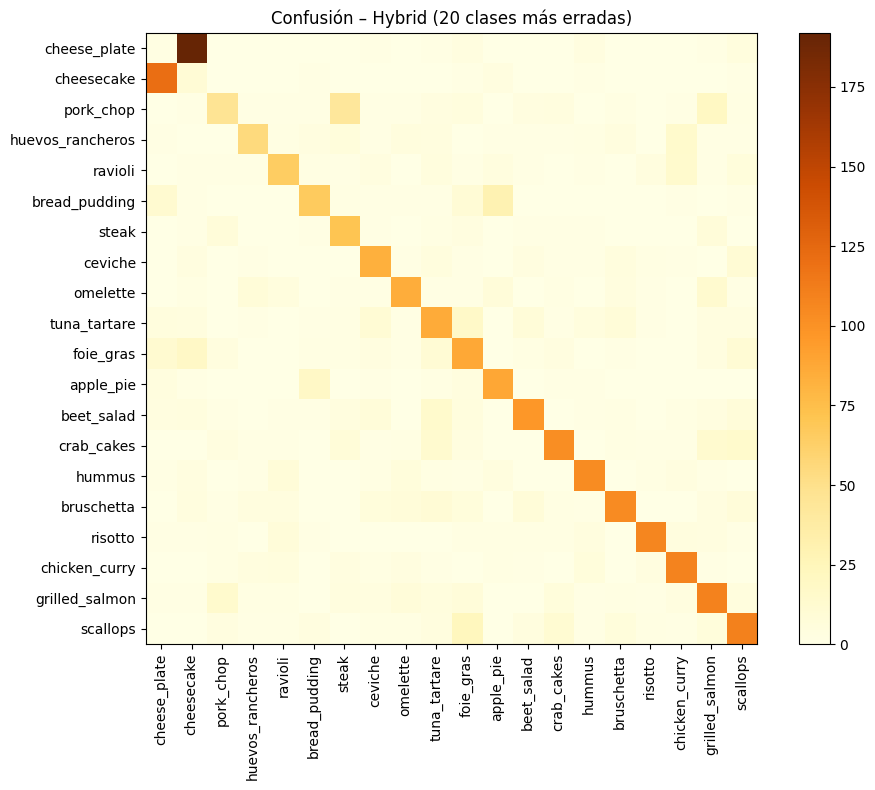

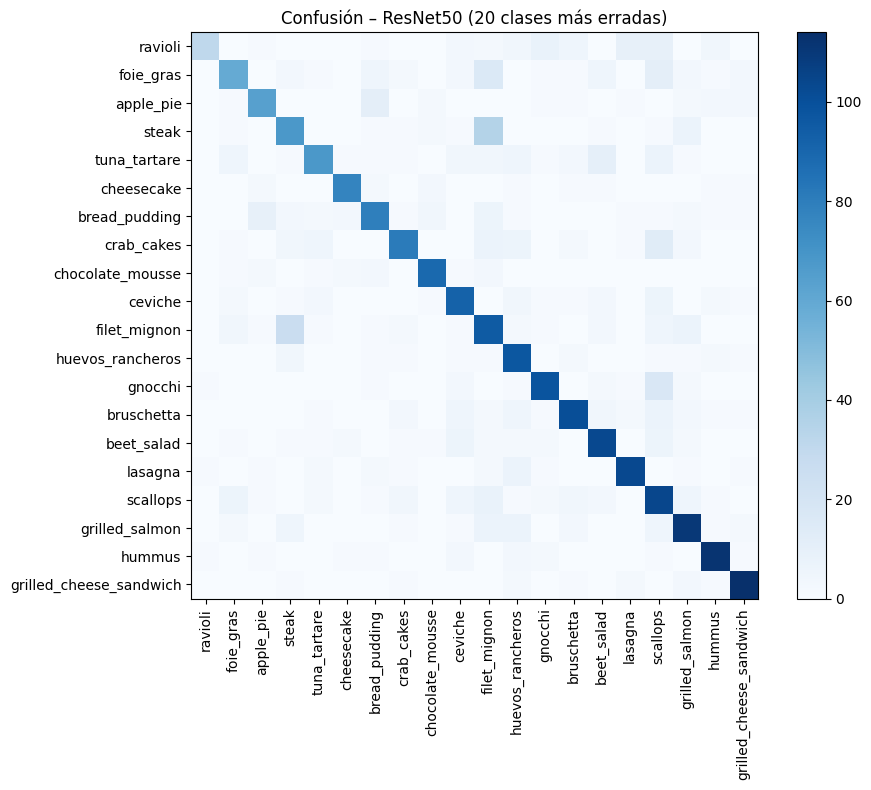

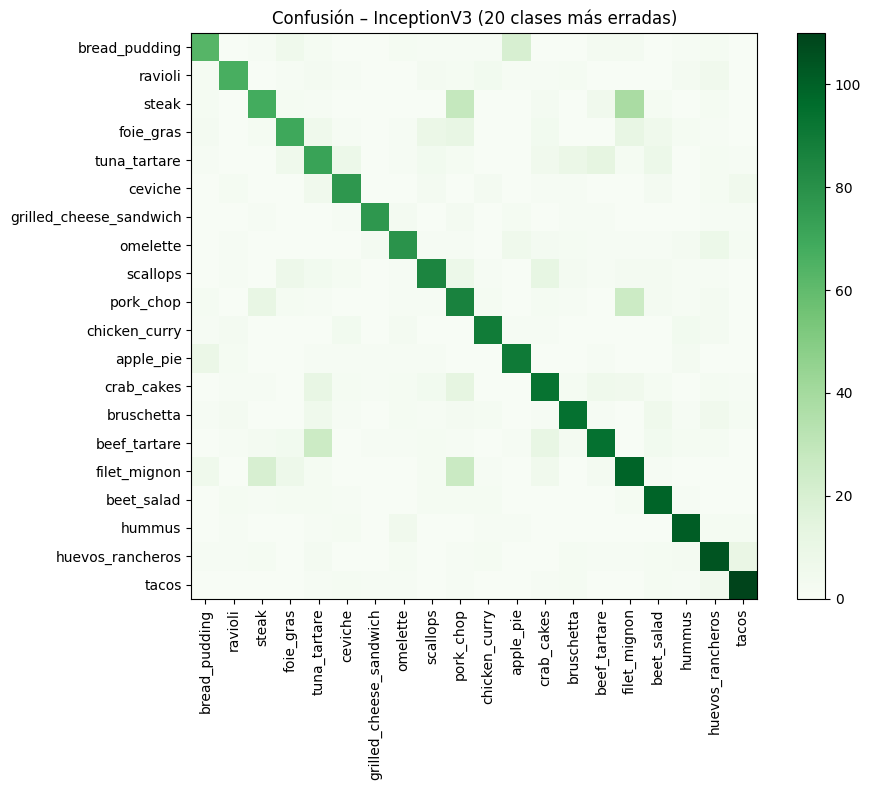

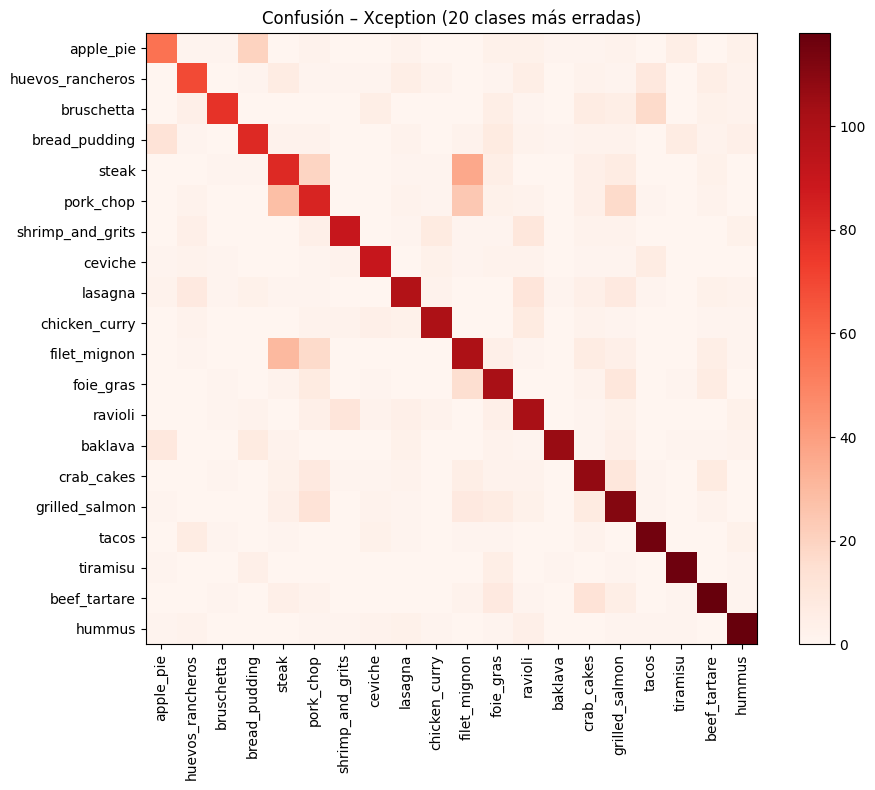


Archivos PNG guardados:
  Hybrid    : /kaggle/working/cm_Hybrid.png
  ResNet50  : /kaggle/working/cm_ResNet50.png
  InceptionV3: /kaggle/working/cm_InceptionV3.png
  Xception  : /kaggle/working/cm_Xception.png

### Test de McNemar (pares de modelos) ###
Hybrid vs ResNet50: χ²=115.04, p=0.0000 ★
Hybrid vs InceptionV3: χ²=126.96, p=0.0000 ★
Hybrid vs Xception: χ²=128.75, p=0.0000 ★
ResNet50 vs InceptionV3: χ²=0.09, p=0.7658 
ResNet50 vs Xception: χ²=0.14, p=0.7108 
InceptionV3 vs Xception: χ²=0.46, p=0.4959 

Puedes descargar cada PNG desde el panel **Files** (carpeta /kaggle/working) o con los enlaces directos que aparecen arriba.


In [7]:
# ─── BLOQUE 4 · MÉTRICAS DETALLADAS + EXPORTACIÓN PNG ─────────────────────
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef
from statsmodels.stats.contingency_tables import mcnemar
import matplotlib.pyplot as plt
import os, numpy as np

# 1. MCC
print('\n### Matthews Correlation Coefficient ###')
for n, pr in preds.items():
    mcc = matthews_corrcoef(y_true, pr)
    print(f'MCC {n:10s}: {mcc:.4f}')

# 2. Matrices de confusión (20 clases con más errores) y guardado en PNG
cmaps = {'Hybrid':'YlOrBr', 'ResNet50':'Blues', 'InceptionV3':'Greens', 'Xception':'Reds'}
png_paths = {}

for n, pr in preds.items():
    cm  = confusion_matrix(y_true, pr)
    err = cm.sum(1) - np.diag(cm)               # errores por clase
    top = err.argsort()[-20:][::-1]             # 20 peores
    sub = cm[np.ix_(top, top)]
    labels = [class_names[i] for i in top]

    plt.figure(figsize=(10, 8))
    plt.imshow(sub, cmap=cmaps[n])
    plt.title(f'Confusión – {n} (20 clases más erradas)')
    plt.xticks(ticks=np.arange(20), labels=labels, rotation=90)
    plt.yticks(ticks=np.arange(20), labels=labels)
    plt.colorbar()
    plt.tight_layout()

    png = f'/kaggle/working/cm_{n}.png'
    plt.savefig(png, dpi=150)
    plt.show()
    png_paths[n] = png
    plt.close()

print("\nArchivos PNG guardados:")
for n, pth in png_paths.items():
    print(f'  {n:10s}: {pth}')

# 3. Test de McNemar (todos contra todos)
print('\n### Test de McNemar (pares de modelos) ###')

def mcnemar_pair(c1, c2):
    n01 = np.sum(np.logical_and(c1, ~c2))
    n10 = np.sum(np.logical_and(~c1, c2))
    if n01 + n10 == 0:   # sin desacuerdos
        return None, None
    tbl = [[0, n01], [n10, 0]]
    res = mcnemar(tbl, exact=False)
    return res.statistic, res.pvalue

names = list(correct.keys())
for i in range(len(names)):
    for j in range(i+1, len(names)):
        s, p = mcnemar_pair(correct[names[i]], correct[names[j]])
        if s is None:
            print(f'{names[i]} vs {names[j]}: sin desacuerdos')
        else:
            sig = '★' if p < 0.05 else ''
            print(f'{names[i]} vs {names[j]}: χ²={s:.2f}, p={p:.4f} {sig}')

print("\nPuedes descargar cada PNG desde el panel **Files** (carpeta /kaggle/working) "
      "o con los enlaces directos que aparecen arriba.")